# Scope of this notebook

This notebook builds on earlier tutorials and focuses on understanding how PyTorch handles **gradients when the output of a computation is a tensor rather than a scalar.**

In particular, it introduces **vector–Jacobian products** (VJPs) as the fundamental object computed by `autograd` when calling `backward()` on **non-scalar outputs**, and shows how upstream gradients control the flow of sensitivity through the computation graph.

The emphasis is on developing conceptual intuition for:
- how gradients are defined for tensor-valued outputs,
- how explicit upstream gradients interact with the computation graph,
- how gradients propagate back to leaf tensors,
- and how PyTorch accumulates and manages gradients across backward passes.

Key topics covered include:
- the distinction between scalar losses and tensor-valued outputs,
- how PyTorch computes vector–Jacobian products via `backward(v)`,
- the role of upstream gradients in shaping `inp.grad`,
- gradient accumulation and the need to explicitly zero gradients,
- and practical interpretation of gradient structure through visualisation.

This notebook is intended as a conceptual bridge between:
- basic autograd usage with scalar losses (Tutorial 2),
- and more advanced topics such as full Jacobians, Jacobian–vector products, and sensitivity analysis (Tutorial 5 and beyond).

It does not cover neural network modules, optimisers, or training pipelines. The focus is strictly on autograd mechanics and gradient interpretation, independent of model architecture.

Recommended prerequisites:
- Familiarity with PyTorch tensors and basic operations
- Understanding of scalar backpropagation and `.backward()`
- Basic comfort with gradients and partial derivatives

---

**Author: Angze Li**

**Last updated: 2026-02-04**

**Version: v1.0**

In [1]:
import torch

### From scalar losses to tensor-valued outputs

In most machine learning workflows, we work with a scalar loss function and compute gradients with respect to model parameters.
This scalar setting allows PyTorch to apply backpropagation automatically, storing gradients directly in `.grad`.

However, not all computations naturally end in a scalar.

In many practical and analytical settings, the output of interest is an arbitrary **tensor** rather than a single number. In such cases, a full gradient is no longer *well-defined* in the usual sense. Instead, the derivative of a tensor-valued function is a **Jacobian matrix**, which can be large and expensive to construct explicitly.

Rather than forming this Jacobian, PyTorch computes Jacobian products efficiently.

Specifically, PyTorch evaluates **vector–Jacobian products** (VJPs), which answer the question:

> How does a weighted combination of the output change with respect to earlier tensors?

In [15]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"leaf tensor inp\n{inp}")
print(f"out\n{out}")
print(f"First call\n{inp.grad}")

leaf tensor inp
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)
out
tensor([[4., 1., 1., 1.],
        [1., 4., 1., 1.],
        [1., 1., 4., 1.],
        [1., 1., 1., 4.],
        [1., 1., 1., 1.]], grad_fn=<TBackward0>)
First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


<details>
<summary><strong>What does the code mean?</strong></summary>
    
#### First Line

```python
torch.eye()
```
creates a identity-like matrix (ones on the diagonal, zeros elsewhere). 

By passing `requires_grad=True`, we tell PyTorch to track all subsequent operations on this tensor so that gradients can be computed during backpropagation.

---

#### Second Line

The variable `out` is now a **tensor-valued output**, not a scalar:
```python
out = (inp+1).pow(2).t()
```
This line performs several operations in sequence:
1. `inp + 1` adds 1 element-wise to the input tensor.
2. `.pow(2)` squares each element, introducing a nonlinear operation (common in machine learning models).
3. `.t()` transposes the matrix, changing its shape.

As a result, out is a matrix, not a single number.

---

#### Third Line: why does `backward()` need an argument here?

In earlier tutorials, we always called backward() on a scalar loss. In that case, PyTorch *implicitly* assumes an upstream gradient of 1.

Here, however, out is not a scalar. Calling:
```python
out.backward()
```
would raise an error, because PyTorch does not know which **combination of gradients** you want.

Instead, we must explicitly provide an upstream gradient with the **same shape** as `out`:
```python
out.backward(torch.ones_like(out), retain_graph=True)
```
This tells PyTorch:
> “Compute the vector–Jacobian product where the upstream gradient is a tensor of ones.”

---

#### Final line: What is `inp.grad` showing us?
After calling:
```python
out.backward(torch.ones_like(out), retain_graph=True)
```
PyTorch computes gradients **with respect to all leaf tensors** that have `requires_grad=True`.
In this example, the only such tensor is:
```python
inp
```
As a result, PyTorch stores the gradient of the output `out` with respect to `inp` in:
```python
inp.grad
```

#### Wait a second...
This could be counter-intuitive for beginners, as the `backward()` is called on `out`, but the gradient is stored on `inp`. 

However, the key mental shift is:
> `backward()` is not asking “what is the gradient of this tensor?”
>
> It is asking “how did this output depend on earlier tensors?”

In PyTorch, when you call:
```python
out.backward(torch.ones_like(out))
```
you are telling PyTorch:
> “Assume out represents the end of a computation.
> 
>Please compute how changes in earlier tensors would affect it.”

More precisely, PyTorch computes:
$$\frac{\partial}{\partial (\text{leaf tensors})}
\Big(v_{\text{upstream}}^{\top}\cdot\text{out}\Big)$$
where:
- $v_{\text{upstream}}$ is the upstream gradient supplied to `backward()` (in our case, `torch.ones_like(out)`, which corresponds to summing all entries of out with **equal weight**; other choices are also valid).
- The expression $v_{\text{upstream}}^{\top}\cdot\text{out}$ is equivalent to $\sum_i v_{\text{upstream},i}\,\text{out}_i$, giving a scalar as the result. This is called **gradient produced via a vector–Jacobian product (VJP)**.
- Only the leaf tensors (see definition in Tutorial 2) accumulate gradients in their `.grad` attribute during backpropagation (in our case, `inp` is the (only) leaf tensor, and hence PyTorch stores the result of the above derivative in `inp.grad`).

Note that mathematically, the gradient (partial derivatives) of a scalar $L$ with respect to a matrix $X \in \mathbb{R}^{m\times n}$ is defined as:
$$\frac{\partial L}{\partial X}
\;=\;
\begin{bmatrix}
\frac{\partial L}{\partial X_{11}} & \cdots & \frac{\partial L}{\partial X_{1n}} \\
\vdots & \ddots & \vdots \\
\frac{\partial L}{\partial X_{m1}} & \cdots & \frac{\partial L}{\partial X_{mn}}
\end{bmatrix}$$

There are (at least) two reasons why PyTorch does not store the gradient in `out`:
1. **`out` is not a parameter.** We don’t usually update out; we update inputs like weights.
2. **Gradients are defined with respect to inputs.** The whole purpose of backpropagation is to answer: “Which earlier values should I change to reduce the output?”


---

#### Important clarification

The need to pass an argument to `backward()` here is not because we want to call `backward()` multiple times. It is because `out` is non-scalar.

The reason we pass `retain_graph=True` is separate:
- it allows the same computation graph to be reused in later cells,
- which is useful for demonstration and debugging.

We will discuss gradient accumulation and zeroing gradients in the next cells.

</details>

In [88]:
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")

if inp.grad is not None:
    inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")


Second call
tensor([[726., 300., 300., 300., 300.],
        [600., 363., 300., 300., 300.],
        [600., 300., 363., 300., 300.],
        [600., 300., 300., 363., 300.]])

Call after zeroing gradients
tensor([[363., 300., 300., 300., 300.],
        [300., 363., 300., 300., 300.],
        [300., 300., 363., 300., 300.],
        [300., 300., 300., 363., 300.]])


<details>
<summary><strong>Gradient accumulation and zeroing gradients</strong></summary>

#### What is happening here?
PyTorch accumulates gradients by default.
This means that every call to `backward()` adds new gradient contributions to the existing values stored in `.grad`.

When we call `backward()` for a second time:
```python
out.backward(torch.ones_like(out), retain_graph=True)
```
without clearing gradients:
- PyTorch computes the same gradient again
- the newly computed gradient is **added to the existing contents** of `inp.grad`

As a result, `inp.grad` after the second call contains the **sum of gradients** from both backward passes, not just the most recent one (we can find that the result of second call is exactly twice as the first call above).

This behaviour is intentional and is essential for many training workflows (e.g. gradient accumulation over multiple mini-batches).

However, when we intend to reset the gradients, we can use:
```python
inp.grad.zero_()
```
This clears the accumulated gradient and sets all entries of `inp.grad` to zero. Now, when we call
```python
out.backward(torch.ones_like(out), retain_graph=True)
```
again:
- PyTorch computes the gradient from scratch
- the result stored in `inp.grad` now reflects only this single backward pass.

Now the result is the same as the first call.

---

#### Why does PyTorch accumulate gradients?
PyTorch’s design assumes that:
- users may want to accumulate gradients across multiple forward–backward passes,
- or combine gradients from multiple loss terms.

Because of this, gradient clearing is an **explicit** user responsibility.

This is why, in typical training loops, you will often see:
```python
optimizer.zero_grad()
```
or 
```python
tensor.grad.zero_()
```
before each backward pass.

</details>

### 🔍 Practical exercise: weighted sensitivity of a tensor output
>In many real problems, a model does not produce a single scalar output.
>Instead, we often care about how sensitive different parts of the output are to changes in the input, possibly with different importance weights.

Consider the following setup:
```python
inp = torch.eye(4, 5, requires_grad=True)
out = (inp + 10).pow(3).t()
```
This produces a tensor-valued output.
Suppose now that we care more about *some entries* of `out` than others.

---
#### 🔧 Task

1. Construct an upstream gradient tensor v with the same shape as out that:
    - assigns higher weight to the first row of out,
    - and lower (or zero) weight elsewhere.
2.	Call:
```python
out.backward(v)
```
3.	Inspect `inp.grad`.

---

#### 🧠 Questions to think about
- How does changing `v` change `inp.grad`?
- Which entries of `inp` are most sensitive to the weighted output?
- What does `inp.grad` represent conceptually in this case?

---

#### 💡 Hint (optional)

>You are not computing “the gradient of out”.
>
>You are computing how a weighted combination of outputs depends on the input.

### Solution:

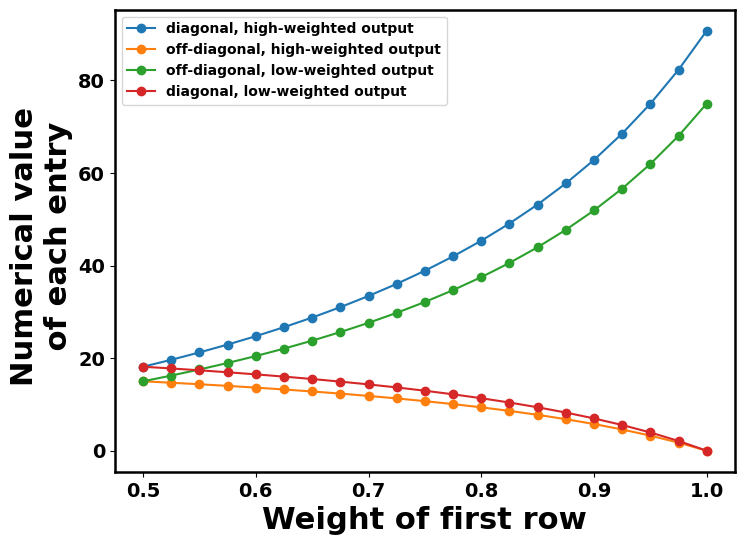

Sum of a 2×2 representative block across weights: [312.6, 312.665, 312.734, 312.808, 312.886, 312.971, 313.061, 313.158, 313.263, 313.377, 313.5, 313.634, 313.781, 313.943, 314.121, 314.318, 314.538, 314.786, 315.065, 315.384, 315.75]


In [95]:
import numpy as np
import matplotlib.pyplot as plt

inp = torch.eye(4, 5, requires_grad=True)
out = (inp + 10).pow(3).t()
#print(f"inp:\n{inp}")
#print(f"out:\n{out}")

entry_00, entry_01, entry_10, entry_11, entry_sum = [], [], [], [], []
weight_list = np.linspace(0.50, 1, 21)

for weight in weight_list:
    v = torch.zeros_like(out)
    v[0, :] = weight
    v[1:, :] = 1 - weight
    v = v / v.sum() #normalisation
    
    if inp.grad is not None:
        inp.grad.zero_()
    out.backward(v, retain_graph=True)
    

    entry_00.append(inp.grad[0,0].item())
    entry_01.append(inp.grad[0,1].item())
    entry_10.append(inp.grad[1,0].item())
    entry_11.append(inp.grad[1,1].item())
    entry_sum.append(round(inp.grad.sum().item(), 3))
    
    #print("weight=", weight)
    #print(f"inp.grad is:\n{inp.grad}")

#-- visualisation part --
plt.figure(figsize=(8,6))
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.8)

plt.plot(weight_list, entry_00, '-o', label = 'diagonal, high-weighted output')
plt.plot(weight_list, entry_01, '-o', label = 'off-diagonal, high-weighted output')
plt.plot(weight_list, entry_10, '-o', label = 'off-diagonal, low-weighted output')
plt.plot(weight_list, entry_11, '-o', label = 'diagonal, low-weighted output')

plt.xlabel("Weight of first row", fontsize=22, fontweight='bold')
plt.ylabel("Numerical value \n of each entry", fontsize=22, fontweight='bold')

plt.legend(loc='upper left',prop={"size": 10, "weight": "bold"})
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

print("Sum of a 2×2 representative block across weights:", entry_sum)

### 🧾 Executive Summary: What did we learn from the exercise?

This exercise used a non-scalar output together with an explicit upstream gradient `v` to probe how gradients flow back to a leaf tensor.

#### 🧠 How does changing v change inp.grad?

Changing `v` does not change what is being differentiated, but it changes how strongly each output entry contributes to the final gradient.
Mathematically, PyTorch computes a vector–Jacobian product, so v acts as a weighting over the rows of out. Increasing the weight of certain outputs amplifies their influence on `inp.grad`, while suppressing others.

---

#### 🧠 Which entries of inp are most sensitive?

Entries of `inp` that:
- lie on the diagonal, and
- correspond to heavily weighted outputs,

receive the largest gradients.
This directly reflects the structure of the forward computation: diagonal elements pass through larger nonlinear transformations, so they dominate gradient flow when their outputs are emphasised.

--- 

#### 🧠 What does `inp.grad` represent conceptually?

`inp.grad` answers the question:

> “If I slightly perturb each entry of inp, how much would the weighted sum of out change?”

It is not the gradient of a single scalar loss, but the gradient of:
$$v_{\text{upstream}}^{\top} \cdot \text{out}$$
with respect to `inp`.

---

#### 🧠 Why is the sum of all entries nearly identical, regardless of weight?

In our experiment, `v` is constructed so that its **total weight is constant** (especially if you normalise `v`, e.g., `v = v / v.sum()`), meaning we are mostly **redistributing** importance across outputs rather than changing the overall “amount” of upstream sensitivity.

Because the forward mapping is element-wise and many entries share the same local derivative structure, this redistribution changes *which* entries in `inp.grad` grow or shrink, but the total across the representative block stays nearly constant (up to floating-point error).